In [1]:
import json
import pandas as pd
import numpy as np
import joblib
from sklearn.metrics import precision_score, roc_auc_score, confusion_matrix, classification_report, average_precision_score, balanced_accuracy_score
import seaborn as sb
import matplotlib.pyplot as plt

np.random.seed(503)

In [2]:
# General parameters for the script
target_name = 'RegisteredInTargetPeriod'  # Target variable
features = [
    'DaysSinceLastRegistration', 'DaysSinceFirstRegistration',
    'PastRegistrations', 'LastDonationLocation_Center',
    'LastDonationType_Platelets', 'CenterRegistrationProportion', 'DonationsPerDay',
    'PlateletRegistrationProportion'
]

# Decide whether we're loading a subset or the full set
# dataset_size = 'partial'
dataset_size = 'full'

if dataset_size == 'full':
    file_names = {
        'X': 'X_test_full.csv',
        'y': 'y_test_full.csv',
        'model': '../../models/classifier_full.pkl'
        # 'model': '../../models/logistic_full.pkl'
        # 'model': '../../models/xgboost_full.pkl'
    }
elif dataset_size == 'partial':
    file_names = {
        'X': 'X_test.csv',
        'y': 'y_test.csv',
        'model': '../../models/classifier.pkl'
        # 'model': '../../models/logistic.pkl'
        # 'model': '../../models/xgboost.pkl'
    }

In [3]:
# Load data
with open('../../data/processed/dtypes.json') as in_file:
    non_date_dtypes = json.load(in_file)

with open('../../data/processed/date_types.json') as in_file:
    date_dtypes = json.load(in_file)

date_cols = list(date_dtypes)

# Read data, specifically parsing date columns as dates and only picking the features + target
X_test = pd.read_csv('../../data/processed/{0}'.format(file_names['X']), dtype=non_date_dtypes, index_col=0)
y_test = pd.read_csv('../../data/processed/{0}'.format(file_names['y']), index_col=0)

C:\Users\rthrw\miniconda3\envs\oneblood-inventory\lib\site-packages\numpy\lib\arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [4]:
# Load model
clf = joblib.load(file_names['model'])

In [5]:
# Score model
y_pred = clf.predict(X_test)
print()
print(classification_report(y_test, y_pred))
print(precision_score(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.94      1.00      0.97   6094080
           1       0.68      0.09      0.16    396687

    accuracy                           0.94   6490767
   macro avg       0.81      0.54      0.57   6490767
weighted avg       0.93      0.94      0.92   6490767

0.6788958047349518


In [6]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print(tn, fp, fn, tp)

6077004 17076 360584 36103


In [7]:
y_pred_prob = clf.predict_proba(X_test)

[Text(0, 0.5, 'Probability')]

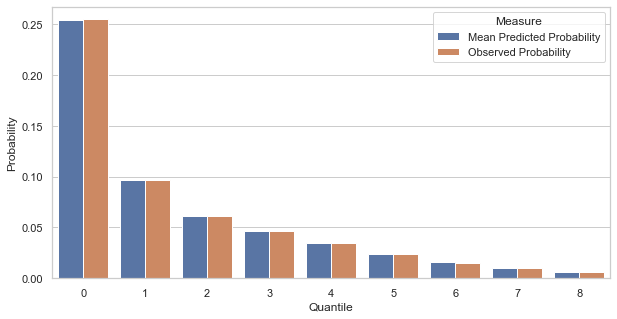

In [8]:
# Do quantile plot for test data
pred_probs = y_pred_prob[:, 1]  # Prediction of positive target

probs_vs_actual = pd.DataFrame(
    np.stack((y_test.squeeze(), pred_probs), axis=1),
    columns=[target_name, 'PredictedProbabilityOfRegistration']
)

# Sort in place
probs_vs_actual.sort_values(by='PredictedProbabilityOfRegistration', ascending=False, inplace=True)

# Assign quantiles
probs_vs_actual['Quantile'] = pd.qcut(-probs_vs_actual['PredictedProbabilityOfRegistration'], 9, labels=False)

# Calculate stats for each quantile: total actual registrations, total donors, and mean predicted probability
quantile_stats = probs_vs_actual.groupby('Quantile').agg({target_name: ['sum', 'count'], 'PredictedProbabilityOfRegistration': ['sum', 'mean']})

# Rename columns
quantile_stats.columns = ['Observed Donations', 'Total In Quantile', 'Predicted Donations', 'Mean Predicted Probability']

# Just get the two variables we care about
quantile_stats['Observed Probability'] = quantile_stats['Observed Donations'] / quantile_stats['Total In Quantile']
quantile_stats.reset_index(inplace=True)

# Melt so we can plot mean predicted probability and actual % registered together
melted_quantile_stats = pd.melt(quantile_stats, id_vars='Quantile', var_name='Measure', value_name='Value')

sb.set(style='whitegrid', rc={'figure.figsize': (10, 5)})
ax = sb.barplot(x='Quantile', y='Value', hue='Measure', data=melted_quantile_stats[melted_quantile_stats['Measure'].isin(('Mean Predicted Probability', 'Observed Probability'))])
ax.set(ylabel='Probability')

[Text(0, 0.5, 'Donations')]

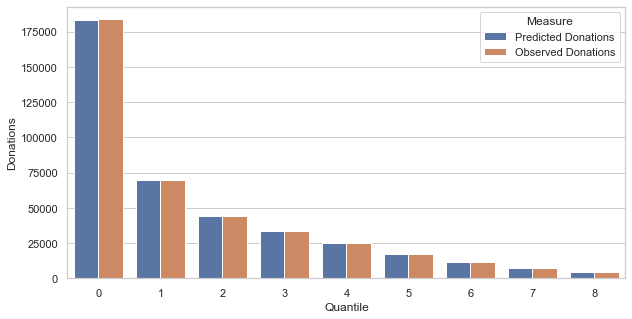

In [9]:
ax = sb.barplot(x='Quantile', y='Value', hue='Measure', data=melted_quantile_stats[melted_quantile_stats['Measure'].isin(('Predicted Donations', 'Observed Donations'))], hue_order=['Predicted Donations', 'Observed Donations'])
ax.set(ylabel='Donations')

In [10]:
quantile_stats['Probability Error'] = np.abs(quantile_stats['Mean Predicted Probability'] - quantile_stats['Observed Probability']) / quantile_stats['Observed Probability']
quantile_stats

,Quantile,Observed Donations,Total In Quantile,Predicted Donations,Mean Predicted Probability,Observed Probability,Probability Error
0,0,183709.0,721198,183500.062047,0.254438,0.254728,0.001137
1,1,69760.0,721195,69574.106726,0.096471,0.096728,0.002665
2,2,44144.0,721774,44299.069557,0.061375,0.061160,0.003513
3,3,33503.0,723300,33627.390149,0.046492,0.046320,0.003713
4,4,25023.0,723825,24917.108820,0.034424,0.034571,0.004232
5,5,17328.0,717057,17351.275441,0.024198,0.024165,0.001343
6,6,11476.0,738654,11490.325048,0.015556,0.015536,0.001248
7,7,7512.0,726858,7603.803380,0.010461,0.010335,0.012221
8,8,4232.0,696906,4247.502087,0.006095,0.006073,0.003663


In [11]:
quantile_stats['Probability Error'].mean()

0.0037483230321691302

In [12]:
predicted_registrations = probs_vs_actual['PredictedProbabilityOfRegistration'].sum()
actual_registrations = probs_vs_actual['RegisteredInTargetPeriod'].sum()
print(f"Predicted registrations: {predicted_registrations}")
print(f"Observed registrations: {actual_registrations}")

Predicted registrations: 396610.6432549524
Observed registrations: 396687.0


In [13]:
np.abs(predicted_registrations - actual_registrations) / actual_registrations

0.00019248612898232405